In [20]:
%run '/home/ihs3/Documents/Notebooks/import_plots.ipynb'
%run '/home/ihs3/Documents/Notebooks/import_getters.ipynb'

## Functions

In [21]:
def getStats(sensor, eventTupleList):
    ''' NAME
            getStats

        DESCRIPTION
            This function uses a list of eventTuples or single tuple and performs statistical analysis 
            on sensor data for each tuple to return a dataframe with mean, max, min, std, skew, kurtosis, 
            and tuple info.  

        INPUT
            sensor:           name of sensor to get data for
            eventTupleList:   can be either a list of eventTuples or a single tuple

        RETURN
            returns a dataframe containing statistical calculations for each event with an index of event ID, 
            reactor, and run

        EXAMPLE
            1.) Multiple Events
            #Get list of Argon events
            dataBase ='rct007'
            gasType ='Argon'
            gasEventsDf = getGasEvents(dataBase,gasType)

            #Get list of tuples for Argon events
            eventTupleList = gasEventsDf.index
            sensor = 'rct_rtd1'

            getStats(sensor, eventTupleList)

            2.) Single Event
            eventTuple = getEvents('rct007').index
            eventNumber = 3
            singleEvent = [eventTuple[eventNumber]]
            sensor = 'rct_rtd1'

            getStats(sensor, singleEvent)'''
    
    list1 = ['mean', 'max', 'min', 'std', 'skew', 'kurt']
    stats = pd.DataFrame(columns = list1)
    df = pd.DataFrame()
    for eventTup in eventTupleList:

        #Get data
        [datetime, data] = getEngData(sensor, eventTup)
        
        #Analyze data
        mean = data.mean()
        maxval = data.max()
        minval = data.min()
        std = data.std()   
        skew1 = sp.stats.skew(data)
        skew = skew1[0]
        kurtosis1 = sp.stats.kurtosis(data, fisher=False)
        kurtosis = kurtosis1[0]
        
        #Compile data
        A = [[mean], [maxval], [minval], [std], [skew], [kurtosis]]
        B = zip(*A)
        df1 = pd.DataFrame(B, columns = list1)        
        stats = pd.concat([stats, df1], axis=0)
    
    #Re-index dataframe with eventTuple info
    index = pd.MultiIndex.from_tuples(eventTupleList, names=['event id', 'reactor', 'run'])
    stats = stats.set_index(index)
    
    return stats

def findInputPower(eventTuple):
    
    ''' NAME
            findInputPower
        
        DESCRIPTION
            This function calculates the input power of the fan and reactor heaters
        
        INPUT
            eventTuple:  contains event ID, run, and database info
        
        RETURN
            returns a calculated value for input power
        
        EXAMPLE
            eventTuple = getEvents('rct007').index
            
            findInputPower(eventTuple[12])'''
    
    lineVoltageSensor = 'v5'
    fanCurrentSensor = 'v8'
    htr1CurrentSensor = 'v1'
    htr2CurrentSensor = 'v4'
    
    datetime, lineVoltage = getEngData(lineVoltageSensor, eventTuple)
    datetime, fanCurrent = getEngData(fanCurrentSensor, eventTuple)
    datetime, h1Current = getEngData(htr1CurrentSensor, eventTuple)
    datetime, h2Current = getEngData(htr2CurrentSensor, eventTuple)

    pwrFan =  lineVoltage * fanCurrent
    pwrHtr1 = lineVoltage * h1Current
    pwrHtr2 = lineVoltage * h2Current
    
    meanPwrFan = pwrFan.mean()
    stdPwrFan = pwrFan.std()
    meanPwrHtr1 = pwrHtr1.mean()
    stdPwrHtr1 = pwrHtr1.std()
    meanPwrHtr2 = pwrHtr2.mean()
    stdPwrHtr2 = pwrHtr2.std()
    
    meanPwr = meanPwrFan+meanPwrHtr1+meanPwrHtr2   
    
    return meanPwr

#For OutputPower function
def density(temp):
    Density = (1.626*(10**-5)*temp**3-6.021*(10**-3)*temp**2+0.021*temp + 1000.066)/1000
    return Density

#For OutputPower function
def specificHeat(temp):
    SH = -3.588*(10**-11)*(temp**5)+1.212*(10**-8)*(temp**4)-1.564*(10**-6)*(temp**3)+1.036*(10**-4)*(temp**2)-3.266*(10**-3)*temp + 4.216
    return SH

def findOutputPower(eventTuples, path = '/home/ihs3/Documents/Notebooks/Data/'):
    #read in flow data
    fi = getEngData('flowin', eventTuples)
    fit = getEngData('flowin_rtd', eventTuples)
    fot = getEngData('flowout_rtd', eventTuples)
    
    #temperatures
    fitmean = fit[1].mean()
    fotmean = fot[1].mean()
    deltaT = fotmean-fitmean
    
    if np.isnan(np.min(fi[1])):
        fi = getEngData('flowout', eventTuples)
        fitmean = fit[1].mean()
        fotmean = fot[1].mean()
        deltaT = fotmean-fitmean

        for x in range(0,len(fi[1])-1):
            if fi[1][x]<fi[1][x-1]:
                time1 = (fi[0][x-1]-fi[0][0]).seconds
                time2 = (fi[0][-1]-fi[0][x]).seconds
                if time1>time2:
                    volumeFlowRate = (fi[1][x-1]-fi[1][0])/time1
                else:
                    volumeFlowRate = (fi[1][-1]-fi[1][x])/time2
                    Qin = volumeFlowRate*density(fitmean)*specificHeat(fitmean)*deltaT*1000
            else:
                pass
    else:
        for x in range(0,len(fi[1])-1):
            if fi[1][x]<fi[1][x-1]:
                time1 = (fi[0][x-1]-fi[0][0]).seconds
                time2 = (fi[0][-1]-fi[0][x]).seconds
                if time1>time2:
                    volumeFlowRate = (fi[1][x-1]-fi[1][0])/time1
                else:
                    volumeFlowRate = (fi[1][-1]-fi[1][x])/time2
                    Qin = volumeFlowRate*density(fitmean)*specificHeat(fitmean)*deltaT*1000
            else:
                pass
    Qin = Qin[0]
    return Qin

def gasPlot(lowArrayIn, lowArrayOut, highArrayIn, highArrayOut, title):
    %matplotlib inline

    # These are the "Tableau 20" colors as RGB.    
    tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(tableau20)):    
        r, g, b = tableau20[i]    
        tableau20[i] = (r / 255., g / 255., b / 255.)    


    sns.set_style("white")
    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=(18, 10))
    ax.scatter(lowArrayIn, (lowArrayOut), s = 30, color=tableau20[12], marker = "o", label = 'Low')
    ax.scatter(highArrayIn, (highArrayOut), s = 30, color=tableau20[14], marker = "s", label = 'High')
    plt.legend(loc = 'upper right')


    plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
    sns.despine(trim=True, left=True, bottom=True)

    ax = sns.regplot(x=np.array(allPowerIn), y=np.array(allPowerOut), ci=99, line_kws={'lw': 2}, color=tableau20[4], scatter=False)

    plt.xlabel('\nPower In $(W)$', fontsize=18)
    plt.ylabel('\nPower Out $(W)$', fontsize=18)
    plt.title(title, fontsize = 20)

## Variables

In [22]:
database = 'rct007'
run = '004'
eventTuple = getEvents(database).index
sensor1 = ''
sensor2 = ''

/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:78: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


## Loop through all events for Power In and Power Out

In [23]:
powerIn = ([])
powerOut = ([])
eventTupleList = ([])

for eventTup in eventTuple:

    powerIn.append(findInputPower(eventTup))
    powerOut.append(findOutputPower(eventTup))
    eventTupleList.append(eventTup)

UnboundLocalError: local variable 'Qin' referenced before assignment

In [ ]:
%matplotlib inline

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
    
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(powerIn, (powerOut), color=tableau20[0])

plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)
ax = sns.regplot(x=np.array(powerIn), y=np.array(powerOut), ci=99, line_kws={'lw': 2}, color=tableau20[6], scatter=False)

plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)
plt.title('All Events', fontsize = 20)


## Loop through gas types separately for Power In and Power Out

In [6]:
gasType1 = 'Argon'
gasEvents1 = getGasEvents(database, gasType1)
argonEventTupleList = gasEvents1.index

gasType2 = 'Helium'
gasEvents2 = getGasEvents(database, gasType2)
heliumEventTupleList = gasEvents2.index

gasType3 = 'Hydrogen'
gasEvents3 = getGasEvents(database, gasType3)
hydrogenEventTupleList = gasEvents3.index

gasType4 = 'Deuterium'
gasEvents4 = getGasEvents(database, gasType4)
deuteriumEventTupleList = gasEvents4.index

/home/ihs3/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:78: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [7]:
gasEvents1_2 = gasEvents1.loc[gasEvents1['Pressure'] == '2']
gasEvents1_15 = gasEvents1.loc[gasEvents1['Pressure'] == '15']
gasEvents2_2 = gasEvents2.loc[gasEvents2['Pressure'] == '2']
gasEvents2_15 = gasEvents2.loc[gasEvents2['Pressure'] == '15']
gasEvents3_2 = gasEvents3.loc[gasEvents3['Pressure'] == '2']
gasEvents3_15 = gasEvents3.loc[gasEvents3['Pressure'] == '15']
gasEvents4_2 = gasEvents4.loc[gasEvents4['Pressure'] == '2']
gasEvents4_15 = gasEvents4.loc[gasEvents4['Pressure'] == '15']

argonLowList = gasEvents1_2.index
argonHighList = gasEvents1_15.index
heliumLowList = gasEvents2_2.index
heliumHighList = gasEvents2_15.index
hydrogenLowList = gasEvents3_2.index
hydrogenHighList = gasEvents3_15.index
deuteriumLowList = gasEvents4_2.index
deuteriumHighList = gasEvents4_15.index

In [8]:
argonLowPowerIn = ([])
argonLowPowerOut = ([])
argonLowPressure = ([])
heliumLowPowerIn = ([])
heliumLowPowerOut = ([])
heliumLowPressure = ([])
hydrogenLowPowerIn = ([])
hydrogenLowPowerOut = ([])
hydrogenLowPressure = ([])
deuteriumLowPowerIn = ([])
deuteriumLowPowerOut = ([])
deuteriumLowPressure = ([])

argonHighPowerIn = ([])
argonHighPowerOut = ([])
argonHighPressure = ([])
heliumHighPowerIn = ([])
heliumHighPowerOut = ([])
heliumHighPressure = ([])
hydrogenHighPowerIn = ([])
hydrogenHighPowerOut = ([])
hydrogenHighPressure = ([])
deuteriumHighPowerIn = ([])
deuteriumHighPowerOut = ([])
deuteriumHighPressure = ([])

lowP = 2
highP = 15

for eventTup in argonLowList:

    argonLowPowerIn.append(findInputPower(eventTup))
    argonLowPowerOut.append(findOutputPower(eventTup))
    argonLowPressure.append(lowP)
    
for eventTup in argonHighList:

    argonHighPowerIn.append(findInputPower(eventTup))
    argonHighPowerOut.append(findOutputPower(eventTup))
    argonHighPressure.append(highP)

for eventTup in heliumLowList:

    heliumLowPowerIn.append(findInputPower(eventTup))
    heliumLowPowerOut.append(findOutputPower(eventTup))
    heliumLowPressure.append(lowP)
    
for eventTup in heliumHighList:

    heliumHighPowerIn.append(findInputPower(eventTup))
    heliumHighPowerOut.append(findOutputPower(eventTup))
    heliumHighPressure.append(highP)
    
for eventTup in hydrogenLowList:

    hydrogenLowPowerIn.append(findInputPower(eventTup))
    hydrogenLowPowerOut.append(findOutputPower(eventTup))
    hydrogenLowPressure.append(lowP)

for eventTup in hydrogenHighList:

    hydrogenHighPowerIn.append(findInputPower(eventTup))
    hydrogenHighPowerOut.append(findOutputPower(eventTup))
    hydrogenHighPressure.append(highP)

for eventTup in deuteriumLowList:

    deuteriumLowPowerIn.append(findInputPower(eventTup))
    deuteriumLowPowerOut.append(findOutputPower(eventTup))
    deuteriumLowPressure.append(lowP)

for eventTup in deuteriumHighList:

    deuteriumHighPowerIn.append(findInputPower(eventTup))
    deuteriumHighPowerOut.append(findOutputPower(eventTup))
    deuteriumHighPressure.append(highP)


In [9]:
allPowerIn = np.concatenate((argonLowPowerIn, argonHighPowerIn, heliumLowPowerIn, heliumHighPowerIn, hydrogenLowPowerIn, hydrogenHighPowerIn, deuteriumLowPowerIn, deuteriumHighPowerIn))
allPowerOut = np.concatenate((argonLowPowerOut, argonHighPowerOut, heliumLowPowerOut, heliumHighPowerOut, hydrogenLowPowerOut, hydrogenHighPowerOut, deuteriumLowPowerOut, deuteriumHighPowerOut))

## Argon Low/High

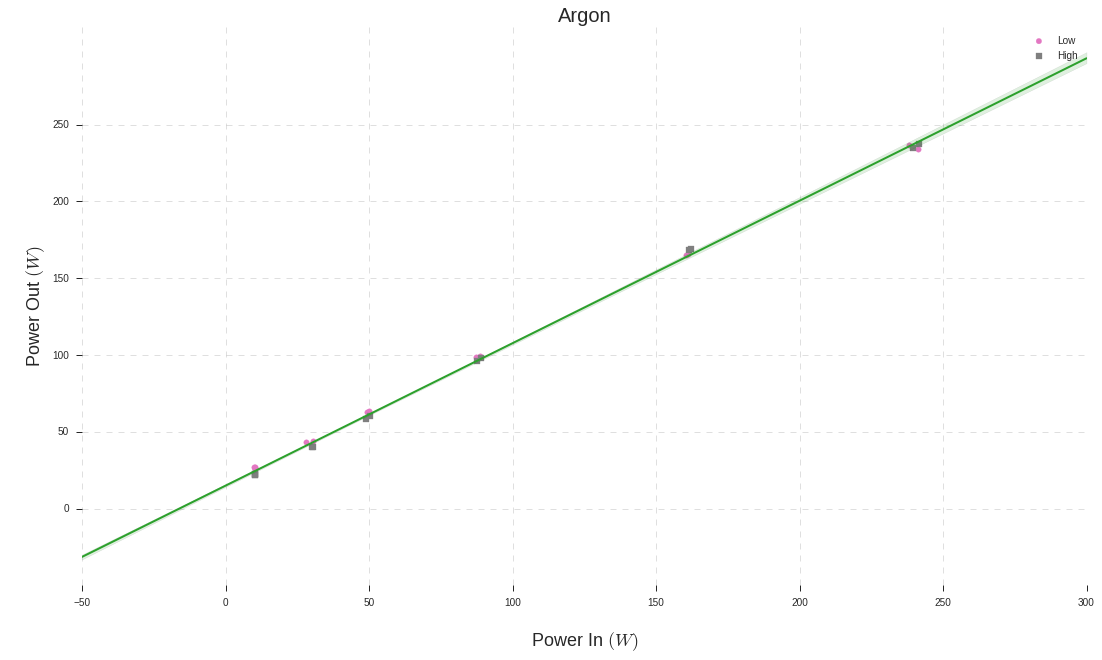

In [10]:
gasPlot(argonLowPowerIn, argonLowPowerOut, argonHighPowerIn, argonHighPowerOut, 'Argon')

## Helium Low/High

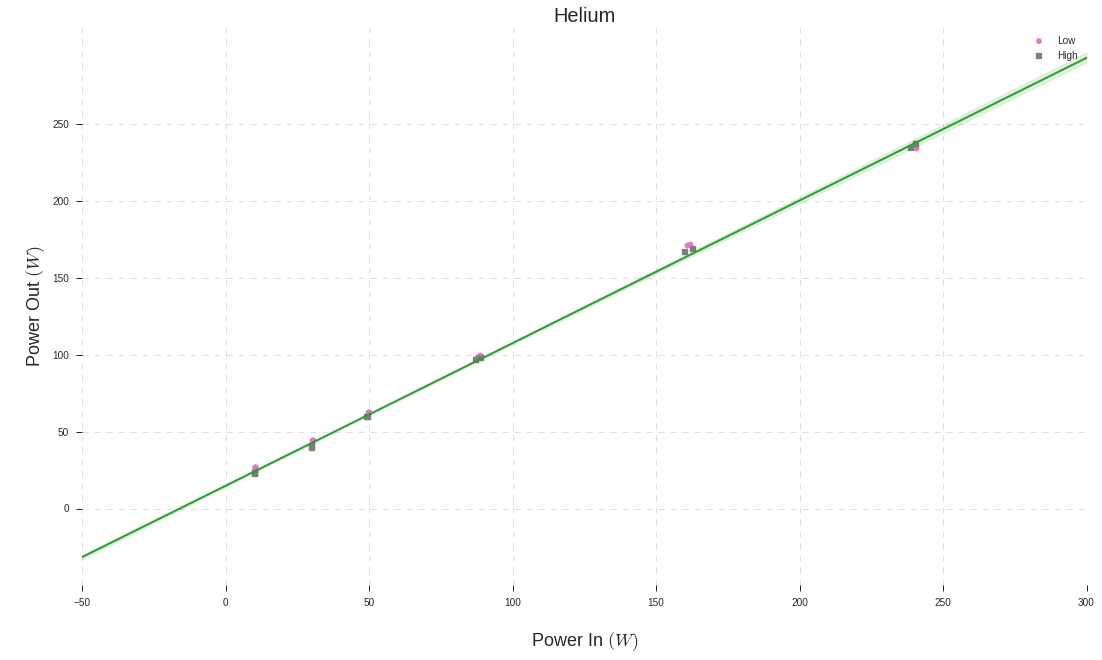

In [11]:
gasPlot(heliumLowPowerIn, heliumLowPowerOut, heliumHighPowerIn, heliumHighPowerOut, 'Helium')

## Hydrogen Low/High

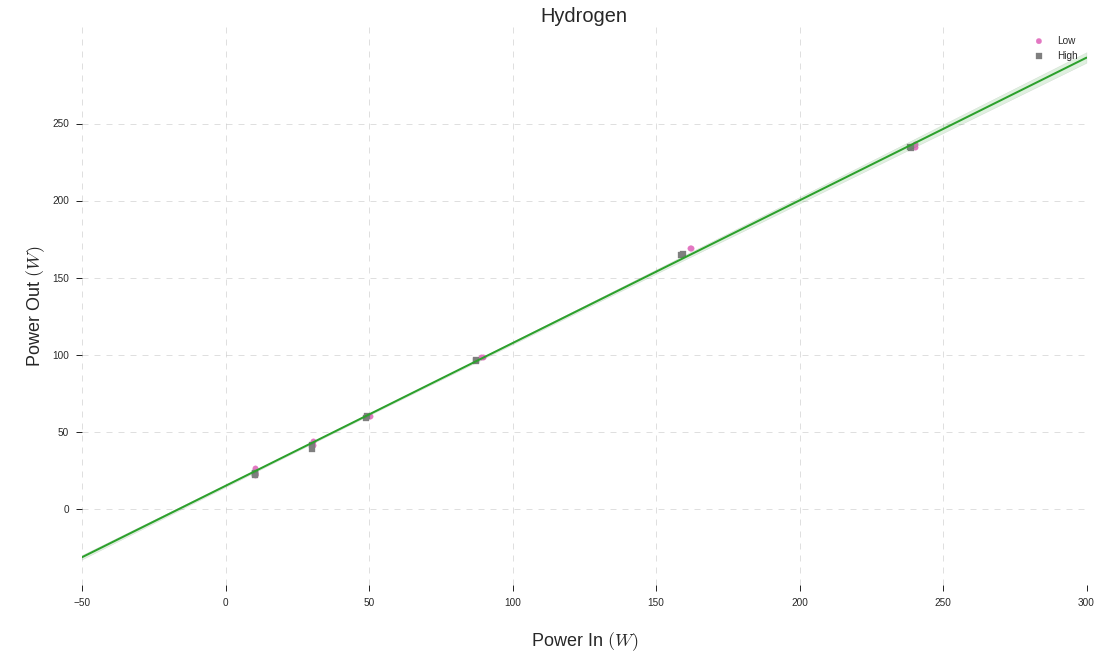

In [12]:
gasPlot(hydrogenLowPowerIn, hydrogenLowPowerOut, hydrogenHighPowerIn, hydrogenHighPowerOut, 'Hydrogen')

ee## Deuterium Low/High

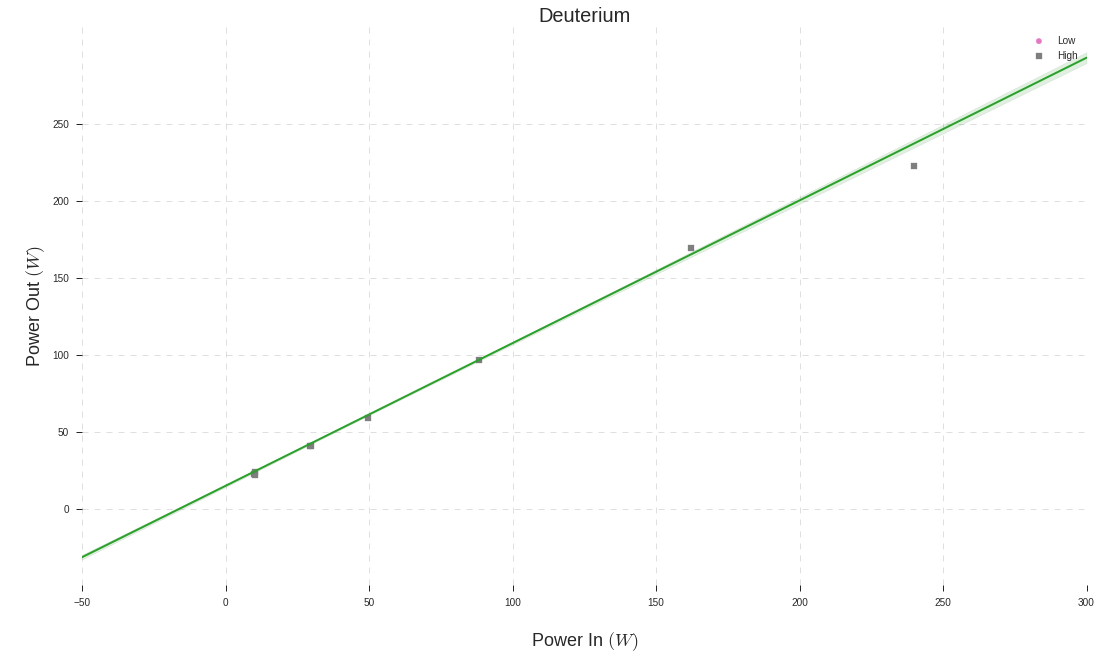

In [13]:
gasPlot(deuteriumLowPowerIn, deuteriumLowPowerOut, deuteriumHighPowerIn, deuteriumHighPowerOut, 'Deuterium')

## All Gases

### %matplotlib inline

# These are the "eee3eeew 2Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
    
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(argonLowPowerIn, (argonHighPowerOut), s = 30, color=tableau20[0], marker = "o", label = 'Argon')
ax.scatter(argonHighPowerIn, (argonHighPowerOut), s = 30, color=tableau20[0], marker = "o")
ax.scatter(heliumLowPowerIn, (heliumLowPowerOut), s = 30, color=tableau20[4], marker = "v", label = 'Helium')
ax.scatter(heliumHighPowerIn, (heliumHighPowerOut), s = 30, color=tableau20[4], marker = "v")
ax.scatter(hydrogenLowPowerIn, (hydrogenLowPowerOut), s = 50, color=tableau20[8], marker = "*", label = 'Hydrogen')
ax.scatter(hydrogenHighPowerIn, (hydrogenHighPowerOut), s = 50, color=tableau20[8], marker = "*")
ax.scatter(deuteriumLowPowerIn, (deuteriumLowPowerOut), s = 30, color=tableau20[12], marker = "D", label = 'Deuterium')
ax.scatter(deuteriumHighPowerIn, (deuteriumHighPowerOut), s = 30, color=tableau20[12], marker = "D")
plt.legend(loc = 'upper right')


plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)

ax = sns.regplot(x=np.array(allPowerIn), y=np.array(allPowerOut), ci=99, line_kws={'lw': 2}, color=tableau20[4], scatter=False)

plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)


